In [8]:
import arviz as az

In [2]:
import argparse
import os
import time

import matplotlib
import matplotlib.pyplot as plt
import numpy as np

from jax import vmap
import jax.numpy as jnp
import jax.random as random
import jax

import numpyro
from numpyro import handlers
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS, Predictive

from scipy import stats
import seaborn as sns
from warnings import filterwarnings

import sklearn
from sklearn import datasets
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons
from sklearn.metrics import mean_squared_error

filterwarnings("ignore")
sns.set_style("white")

cmap = sns.diverging_palette(250, 12, s=85, l=25, as_cmap=True)
cmap_uncertainty = sns.cubehelix_palette(light=1, as_cmap=True)

layer_names = ["w1_c", "w2_c", "w3_c"]

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib
from math import sqrt
SPINE_COLOR = 'gray'


def latexify(fig_width=None, fig_height=None, columns=1):
    """Set up matplotlib's RC params for LaTeX plotting.
    Call this before plotting a figure.

    Parameters
    ----------
    fig_width : float, optional, inches
    fig_height : float,  optional, inches
    columns : {1, 2}
    """

    # code adapted from http://www.scipy.org/Cookbook/Matplotlib/LaTeX_Examples

    # Width and max height in inches for IEEE journals taken from
    # computer.org/cms/Computer.org/Journal%20templates/transactions_art_guide.pdf

    assert(columns in [1,2])

    if fig_width is None:
        fig_width = 3.39 if columns==1 else 6.9 # width in inches

    if fig_height is None:
        golden_mean = (sqrt(5)-1.0)/2.0    # Aesthetic ratio
        fig_height = fig_width*golden_mean # height in inches

    MAX_HEIGHT_INCHES = 8.0
    if fig_height > MAX_HEIGHT_INCHES:
        print("WARNING: fig_height too large:" + fig_height + 
              "so will reduce to" + MAX_HEIGHT_INCHES + "inches.")
        fig_height = MAX_HEIGHT_INCHES

    params = {'backend': 'ps',
              'text.latex.preamble': r'\usepackage{gensymb}',
              'axes.labelsize': 8, # fontsize for x and y labels (was 10)
              'axes.titlesize': 8,
              'font.size': 8, # was 10
              'legend.fontsize': 8, # was 10
              'xtick.labelsize': 8,
              'ytick.labelsize': 8,
              'text.usetex': True,
              'figure.figsize': [fig_width,fig_height],
              'font.family': 'serif'
    }

    matplotlib.rcParams.update(params)


def format_axes(ax):

    for spine in ['top', 'right']:
        ax.spines[spine].set_visible(False)

    for spine in ['left', 'bottom']:
        ax.spines[spine].set_color(SPINE_COLOR)
        ax.spines[spine].set_linewidth(0.5)

    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')

    for axis in [ax.xaxis, ax.yaxis]:
        axis.set_tick_params(direction='out', color=SPINE_COLOR)

    return ax

latexify()

# HBNN for 1d regression

Predicting on the different Amplitudes

In [4]:
def generate_data(num_samples, phase_shift = 0, frequency = 1, func = np.sin, amplitude = 1):
    x = np.random.uniform(-5, 5, num_samples)
    y =  amplitude*func(frequency*x + phase_shift)
    return x, y
n_samples = 50
# context_points = list(range(10, n_samples + 1,10 ))
context_points = [1,2,3,4,5, 10, 20, 30, 40, 45]
amplitudes = [1, 2, 3, 5]

# fixed points
X_train_data, Y_train_data = [], []
X_test_data, Y_test_data = [], []
for i in range(len(amplitudes)):
    xx, yy = generate_data(num_samples=n_samples, amplitude=amplitudes[i])
    if i == len(amplitudes) - 1:
        X_test_data = xx
        Y_test_data = yy
    else :
        X_train_data.append(xx)
        Y_train_data.append(yy)

# different context
contexts_x, contexts_y = [], []
for contexts in context_points:
    x_new = np.tile(X_test_data[: contexts], (n_samples//contexts +1))
    y_new = np.tile(Y_test_data[: contexts], n_samples//contexts + 1)
    x_new = x_new[: n_samples]
    y_new = y_new[: n_samples]
    contexts_x.append(x_new)
    contexts_y.append(y_new)

contexts_y = np.array(contexts_y)
contexts_x = np.array(contexts_x)
# X_test_data = np.linspace(-5, 5, n_samples)
# Y_test_data = amplitudes[-1]*np.sin(X_test_data)
X_train_data = np.array(X_train_data)
Y_train_data = np.array(Y_train_data)
X_test_data = np.array(X_test_data)
Y_test_data = np.array(Y_test_data)


In [5]:
contexts_x

array([[ 2.63808058,  2.63808058,  2.63808058,  2.63808058,  2.63808058,
         2.63808058,  2.63808058,  2.63808058,  2.63808058,  2.63808058,
         2.63808058,  2.63808058,  2.63808058,  2.63808058,  2.63808058,
         2.63808058,  2.63808058,  2.63808058,  2.63808058,  2.63808058,
         2.63808058,  2.63808058,  2.63808058,  2.63808058,  2.63808058,
         2.63808058,  2.63808058,  2.63808058,  2.63808058,  2.63808058,
         2.63808058,  2.63808058,  2.63808058,  2.63808058,  2.63808058,
         2.63808058,  2.63808058,  2.63808058,  2.63808058,  2.63808058,
         2.63808058,  2.63808058,  2.63808058,  2.63808058,  2.63808058,
         2.63808058,  2.63808058,  2.63808058,  2.63808058,  2.63808058],
       [ 2.63808058, -2.82341374,  2.63808058, -2.82341374,  2.63808058,
        -2.82341374,  2.63808058, -2.82341374,  2.63808058, -2.82341374,
         2.63808058, -2.82341374,  2.63808058, -2.82341374,  2.63808058,
        -2.82341374,  2.63808058, -2.82341374,  2.

In [6]:
contexts_x.shape, contexts_y.shape, X_test_data.shape, Y_test_data.shape, X_train_data.shape, Y_train_data.shape


((10, 50), (10, 50), (50,), (50,), (3, 50), (3, 50))

In [7]:
def hierarchical_nn(X, Y, D_H):
    # print(f"X shape", X.shape)
    D_Y = 1 # output dim
    D_C = 4 # different tasks
    D_X = 1 # input dimensions

    # print(X.shape)
    # Group mean distribution for input to hidden layer
    mu_1 = numpyro.sample("mu_1", dist.Normal(jnp.zeros((D_X, D_H)), jnp.ones((D_X, D_H))))  # D_X D_H
    # Group standard-deviation
    sigma_1 = numpyro.sample("sigma_1", dist.HalfNormal(1.0))

    # sample second layer
    mu_2 = numpyro.sample("mu_2", dist.Normal(jnp.zeros((D_H, D_H)), jnp.ones((D_H, D_H))))  # D_H D_H
    sigma_2 = numpyro.sample("sigma_2", dist.HalfNormal(1.0))

    # sample final layer of weights and neural network output
    mu_3 = numpyro.sample("mu_3", dist.Normal(jnp.zeros((D_H, D_Y)), jnp.ones((D_H, D_Y))))  # D_H D_Y
    sigma_3 = numpyro.sample("sigma_3", dist.HalfNormal(1.0))

    # print(f"shpae mu 1, 2, 3 {mu_1.shape, mu_2.shape, mu_3.shape}")
    # print(f"shape sigma 1,2,3, { sigma_1.shape, sigma_2.shape, sigma_3.shape}")

    w1_all = numpyro.sample("w1_all", dist.Normal(jnp.zeros((D_C, D_X, D_H)), jnp.ones((D_C, D_X, D_H))))  # D_C D_X D_H
    w2_all = numpyro.sample("w2_all", dist.Normal(jnp.zeros((D_C, D_H, D_H)), jnp.ones((D_C, D_H, D_H))))  # D_C D_H D_H
    w3_all = numpyro.sample("w3_all", dist.Normal(jnp.zeros((D_C, D_H, D_Y)), jnp.ones((D_C, D_H, D_Y))))  # D_C D_H D_Y

    w1 = w1_all * sigma_1 + mu_1
    w2 = w2_all * sigma_2 + mu_2
    w3 = w3_all * sigma_3+ mu_3
    # print(f"shape - w1 w2 w3 {w1.shape, w2.shape, w3.shape}") # w1 shape = D_C * D_X * D_H
    # print(f"shape - X {X.shape}") X shape D_C * D_X * D_H
    X = X.reshape(D_C, -1, D_X)
    z1 = jnp.tanh(jnp.matmul(X, w1))  # D_C N D_H  <= first layer of activations
    z2 = jnp.tanh(jnp.matmul(z1, w2))  # D_C N D_H  <= second layer of activations
    z3 = jnp.matmul(z2, w3)  # D_C N D_Y  <= output of the neural network 
    # print(f"shape z 1, 2, 3 {z1.shape, z2.shape, z3.shape}")
    sigma = numpyro.sample("sigma", dist.HalfNormal(1))
    Y = numpyro.sample("Y", dist.Normal(z3, sigma), obs=Y.reshape((D_C, -1, 1)) if Y is not None else Y)

In [8]:
def run_inference(model, rng_key, args, **kwargs):
    kernel = NUTS(model)
    mcmc = MCMC(
        kernel,
        num_warmup=args["num_warmup"],
        num_samples=args["num_samples"],
        num_chains=args["num_chains"],
        progress_bar=True,
    )
    mcmc.run(rng_key, **kwargs)
    return mcmc

def get_predictions(model, rng_key, samples, X, D_H, args, bnn_kwargs):
    # helper function for prediction
    def predict(model, rng_key, samples, X, D_H, bnn_kwargs):
        model = handlers.substitute(handlers.seed(model, rng_key), samples)
        # note that Y will be sampled in the model because we pass Y=None here
        model_trace = (
            handlers.trace(model).get_trace(X=X, Y=None, D_H=D_H)
            if bnn_kwargs is None
            else handlers.trace(model).get_trace(X=X, Y=None, D_H=D_H, **bnn_kwargs)
        )

        return model_trace["Y"]["value"]

    # predict Y at inputs X
    vmap_args = (samples, random.split(rng_key, args["num_samples"] * args["num_chains"]))
    predictions = vmap(lambda samples, rng_key: predict(model, rng_key, samples, X, D_H, bnn_kwargs))(*vmap_args)
    return predictions

def get_mean_predictions(predictions):
    predictions = predictions[..., 0] # making it dimension num_sample * D_C * points
    # compute mean prediction and confidence interval around median
    mean_prediction = jnp.mean(predictions, axis=0)
    return mean_prediction 

def get_std_predictions(predictions):
    predictions = predictions[..., 0]
    std = jnp.std(predictions, axis=0)
    return std



def fit_and_eval(model, X_train, X_test, Y_train, Y_test, D_H, args, bnn_kwargs=None):
    # values to be returned
    pred_train, pred_test, pred_grid = [], [], []

    # do inference
    kwargs = {"X": X_train, "Y": Y_train, "D_H": D_H}
    if bnn_kwargs:
        kwargs = {**kwargs, **bnn_kwargs}

    rng_key, rng_key_train, rng_key_test, rng_key_grid = random.split(random.PRNGKey(0), 4)
    mcmc = run_inference(model, rng_key, args, **kwargs)
    samples = mcmc.get_samples()
    # # predict Y_train and Y_test at inputs X_traind and X_test, respectively
    predictions = get_predictions(model, rng_key_train, samples, X_train, D_H, args, bnn_kwargs)
    mean_prediction = get_mean_predictions(predictions)
    pred_train = mean_prediction

    predictions = get_predictions(model, rng_key_test, samples, X_test, D_H, args, bnn_kwargs)
    # print(f"Prediction test {predictions.shape}")
    mean_prediction = get_mean_predictions(predictions)
    # print(f"Mean Test Predictions {mean_prediction.shape}")
    pred_test = mean_prediction

    std_pred_test = get_std_predictions(predictions)
    
    # pred_train = []
    # pred_test = []
    return pred_train, pred_test,  std_pred_test, mcmc


shape - X_test, X_train Y_test, Y_train ((4, 50), (4, 50), (4, 50), (4, 50))


sample: 100%|██████████| 150/150 [00:01<00:00, 103.22it/s, 358 steps of size 3.56e-04. acc. prob=0.56]


context points: 1 mse: 14.627890456696116
shape - X_test, X_train Y_test, Y_train ((4, 50), (4, 50), (4, 50), (4, 50))


sample: 100%|██████████| 150/150 [00:01<00:00, 82.96it/s, 1023 steps of size 4.80e-04. acc. prob=0.96]


context points: 2 mse: 3.021702904665357
shape - X_test, X_train Y_test, Y_train ((4, 50), (4, 50), (4, 50), (4, 50))


sample: 100%|██████████| 150/150 [00:01<00:00, 95.75it/s, 359 steps of size 4.22e-04. acc. prob=0.61] 


context points: 3 mse: 1.0067013025981237
shape - X_test, X_train Y_test, Y_train ((4, 50), (4, 50), (4, 50), (4, 50))


sample: 100%|██████████| 150/150 [00:01<00:00, 83.26it/s, 1023 steps of size 5.31e-04. acc. prob=0.94]


context points: 4 mse: 0.33092728251174436
shape - X_test, X_train Y_test, Y_train ((4, 50), (4, 50), (4, 50), (4, 50))


sample: 100%|██████████| 150/150 [00:01<00:00, 85.41it/s, 1023 steps of size 6.84e-04. acc. prob=0.84]


context points: 5 mse: 0.06651795674815233
shape - X_test, X_train Y_test, Y_train ((4, 50), (4, 50), (4, 50), (4, 50))


sample: 100%|██████████| 150/150 [00:01<00:00, 83.67it/s, 1023 steps of size 1.11e-03. acc. prob=0.85]


context points: 10 mse: 0.03262902869682448
shape - X_test, X_train Y_test, Y_train ((4, 50), (4, 50), (4, 50), (4, 50))


sample: 100%|██████████| 150/150 [00:01<00:00, 93.47it/s, 1023 steps of size 1.04e-03. acc. prob=0.56]


context points: 20 mse: 0.013311488733051234
shape - X_test, X_train Y_test, Y_train ((4, 50), (4, 50), (4, 50), (4, 50))


sample: 100%|██████████| 150/150 [00:01<00:00, 98.91it/s, 265 steps of size 7.53e-04. acc. prob=0.60] 


context points: 30 mse: 0.002721781122598174
shape - X_test, X_train Y_test, Y_train ((4, 50), (4, 50), (4, 50), (4, 50))


sample: 100%|██████████| 150/150 [00:01<00:00, 109.14it/s, 229 steps of size 1.21e-03. acc. prob=0.47]


context points: 40 mse: 0.0017314751637655308
shape - X_test, X_train Y_test, Y_train ((4, 50), (4, 50), (4, 50), (4, 50))


sample: 100%|██████████| 150/150 [00:01<00:00, 86.07it/s, 372 steps of size 1.00e-03. acc. prob=0.84] 


context points: 45 mse: 0.002177643944838161


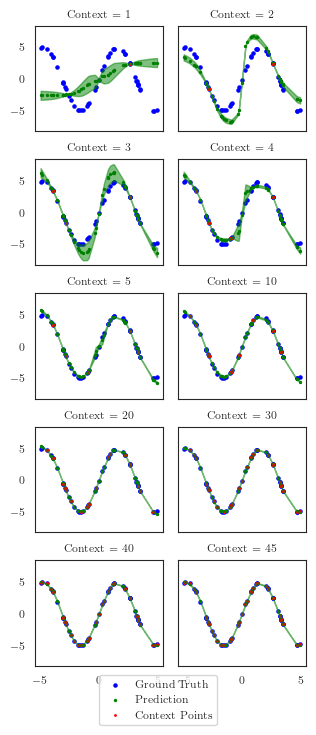

In [26]:
D_H = 5
args = {"num_samples": 50, "num_chains": 2, "num_warmup": 100}

mse_list_hbnn_medium = []

fig, axs = plt.subplots(figsize=(3.2, 7), nrows=5, ncols=2, sharex=True, sharey=True)
axs = axs.flatten()
for i in range(len(context_points)):
    X_train = np.concatenate( (X_train_data, contexts_x[i].reshape(1, n_samples)), axis=0)
    Y_train = np.concatenate((Y_train_data, contexts_y[i].reshape(1, n_samples)) , axis = 0)
    X_test = np.concatenate((X_train_data, X_test_data.reshape(1, n_samples) ), axis = 0)
    Y_test = np.concatenate((Y_train_data, Y_test_data.reshape(1, n_samples)), axis = 0)

    print(f"shape - X_test, X_train Y_test, Y_train {X_test.shape, X_train.shape, Y_test.shape, Y_train.shape}")
    # print(X_train[-1][: 10])

    Y_hierarchical_pred_train, Y_hierarchical_pred_test, std_pred_test, mcmc_hier = fit_and_eval(hierarchical_nn, X_train, X_test, Y_train, Y_test, D_H, args )
    # print(f"std_pred_test shape: {std_pred_test.shape}")
    # print(Y_hierarchical_pred_test.shape)
    test_error = mean_squared_error(Y_test[-1], Y_hierarchical_pred_test[-1])
    mse_list_hbnn_medium.append(test_error)
    print(f"context points: {context_points[i]} mse: {test_error}")
    lb = Y_hierarchical_pred_test[-1] - std_pred_test[-1]
    ub = Y_hierarchical_pred_test[-1] + std_pred_test[-1]
    # print(f"shape lb, up: {lb.shape, ub.shape}")
    # print(f"lb {lb}\n ub {ub}")
    axs[i].scatter(X_test[-1], Y_test[-1], label = 'Ground Truth',color = 'b', s = 5)
    axs[i].scatter(X_test[-1],Y_hierarchical_pred_test[-1], label = 'Prediction',color = 'g', s = 2)
    axs[i].scatter(X_train[-1], Y_train[-1], label = 'Context Points',color = 'r', s = 1)
    ft = np.concatenate((X_test[-1].reshape(50, 1), ub.reshape(50,1), lb.reshape(50,1)), axis = 1)
    ft = ft[ft[:, 0].argsort()]
    axs[i].fill_between(ft[:, 0], ft[:,1], ft[:, 2], alpha = 0.5, color = 'g')
    axs[i].set_title(f"Context = {context_points[i]}")
    # break
    # break
fig.legend(loc='upper center', labels=['Ground Truth', 'Prediction', 'Context Points'], bbox_to_anchor=(0.5, 0.04))
plt.tight_layout()
plt.savefig("plots/sin_hbnn_medium_4amp.pdf", format="pdf", bbox_inches="tight")
plt.show()

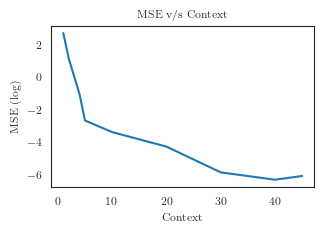

In [27]:
fig, ax = plt.subplots()  # Width = 3*5 inches, Height = 5 inches
plt.plot(context_points, np.log( np.array(mse_list_hbnn_medium)))
plt.title("MSE v/s Context")
plt.xlabel("Context")
plt.ylabel("MSE (log)")
ax.tick_params(axis='both', which='both', labelsize=8)
plt.savefig("plots/sin_hbnn_performance_medium.pdf", format="pdf", bbox_inches="tight")
plt.show()

# CNP on the same data

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
import torch


class Encoder(nn.Module):
    def __init__(self, layout, activation = torch.relu):
        super(Encoder, self).__init__()
        self.layers = nn.ModuleList()
        self.activation = activation
        for i in range(len(layout)):
            self.layers.append(nn.Linear(layout[i][0], layout[i][1]))

    def forward(self, x):
        for layer in self.layers[: -1]:
            x = self.activation(layer(x))
        x = self.layers[-1](x)
        return x

class Decoder(nn.Module):
    def __init__(self, layout, activation):
        super(Decoder, self).__init__()
        self.layers = nn.ModuleList()
        self.activation = activation
        for i in range(len(layout)):
            self.layers.append(nn.Linear(layout[i][0], layout[i][1]))

        
    def forward(self, x):
        for layer in self.layers[: -1]:
            x = self.activation(layer(x))
        x = self.layers[-1](x)
        return x

class Aggregator(nn.Module):
    def __init__(self):
        super(Aggregator, self).__init__()
        
    def forward(self, x):
        return torch.mean(x, dim=0)

class CNP(nn.Module):
    def __init__(self, layout_encoder, layout_decoder, activation):
        super(CNP, self).__init__()
        self.encoder = Encoder(layout_encoder, activation)
        self.decoder = Decoder(layout_decoder, activation)
        self.aggregator = Aggregator()
        
    def forward(self, contextx, contexty, targetx):
        context = torch.cat([contextx, contexty], dim=1)
        encoded_context = self.encoder(context)
        aggregated = self.aggregator(encoded_context)
        decoder_input = torch.cat([aggregated.unsqueeze(0).expand(len(targetx),-1), targetx.view(-1, contextx.shape[1])], dim=1)
        output = self.decoder(decoder_input)
        return output



In [ ]:
contexts_x.shape, contexts_y.shape, X_test_data.shape, Y_test_data.shape, X_train_data.shape, Y_train_data.shape


((10, 50), (10, 50), (50,), (50,), (3, 50), (3, 50))

(4, 50) (4, 50) (4, 50) (4, 50)


100%|██████████| 1000/1000 [00:01<00:00, 589.21it/s]


35.76475463714187
(4, 50) (4, 50) (4, 50) (4, 50)


100%|██████████| 1000/1000 [00:01<00:00, 583.12it/s]


10.552198251993016
(4, 50) (4, 50) (4, 50) (4, 50)


100%|██████████| 1000/1000 [00:01<00:00, 638.74it/s]


5.312669685175468
(4, 50) (4, 50) (4, 50) (4, 50)


100%|██████████| 1000/1000 [00:01<00:00, 681.71it/s]


2.416224106672084
(4, 50) (4, 50) (4, 50) (4, 50)


100%|██████████| 1000/1000 [00:01<00:00, 636.14it/s]


0.9929691400786258
(4, 50) (4, 50) (4, 50) (4, 50)


100%|██████████| 1000/1000 [00:01<00:00, 692.61it/s]


0.6692767185524267
(4, 50) (4, 50) (4, 50) (4, 50)


100%|██████████| 1000/1000 [00:01<00:00, 694.67it/s]


0.2578802878737103
(4, 50) (4, 50) (4, 50) (4, 50)


100%|██████████| 1000/1000 [00:01<00:00, 687.21it/s]


0.15865758555590062
(4, 50) (4, 50) (4, 50) (4, 50)


100%|██████████| 1000/1000 [00:01<00:00, 672.88it/s]


0.1591281770671503
(4, 50) (4, 50) (4, 50) (4, 50)


100%|██████████| 1000/1000 [00:01<00:00, 687.11it/s]


0.07818077109361124


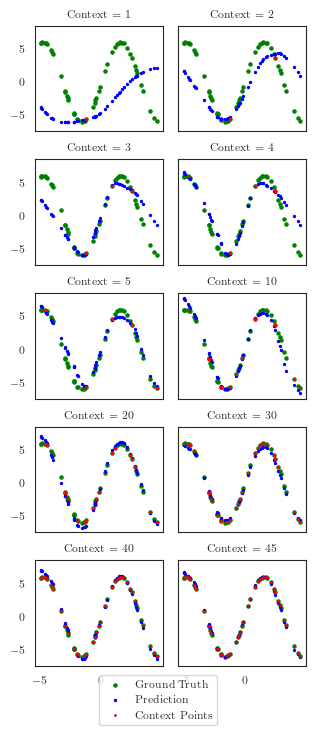

In [ ]:
import torch.optim as optim
from sklearn.metrics import mean_squared_error
from tqdm import tqdm

def train_cnp_1d(X_train, Y_train, num_contexts, num_epochs = 1000, num_samples = 50,  context_size = 10, target_size= 30):
    # CNP model
    encoder_layout = [[2, 256], [256, 256], [256, 256], [256, 128]]
    decoder_layout = [[129, 256], [256, 256], [256, 256], [256, 1]]
    model = CNP(encoder_layout, decoder_layout, torch.relu)


    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    losses = []
    
    for epoch in tqdm(range(num_epochs)):
        context=np.random.choice(num_samples, context_size, replace=False)
        target=np.random.choice(num_samples, target_size, replace=False)
        train_set=np.random.randint(0, 4)

        if train_set == 3:
            # ind = np.random.randint(0, num_contexts)
            context = np.random.choice(num_contexts, min(context_size, num_contexts), replace= False)
            target = np.random.choice(num_contexts, min(context_size, num_contexts), replace = False)


        target_x = X_train[train_set][target]
        target_y = Y_train[train_set][target]
        context_x_ = X_train[train_set][context]
        context_y_ = Y_train[train_set][context]


        context_x_ = torch.tensor(context_x_, dtype=torch.float32).view(-1 ,1)
        context_y_ = torch.tensor(context_y_, dtype=torch.float32).view(-1, 1)
        target_x = torch.tensor(target_x, dtype=torch.float32).view(-1,1)
        target_y = torch.tensor(target_y, dtype=torch.float32).view(-1, 1)

        # training the model with back propagation
        model.train()
        optimizer.zero_grad()
        predictions = model(context_x_, context_y_, target_x)
        # print(f"shape -> predictions {predictions.shape} target_y {target_y.shape}")
        loss = criterion(predictions, target_y.view(-1, 1))
        loss.backward()
        optimizer.step()
        # print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")
        if epoch % 10 == 0 :
            losses.append(loss.item())

        # print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")
    # plt.plot(np.arange(num_epochs), np.log(losses))
    # plt.xlabel('Epochs')
    # plt.ylabel("Loss (Log)")
    # plt.title("Loss vs Epoch")
    # plt.show()
    return model

def testing(model, context_x, context_y, X_test, context_size = 30, num_context = 10):
    
    target_x = X_test
    # rand_points = np.random.choice(num_context, min(context_size, num_context), replace=False)
    rand_points = np.random.choice(len(context_x), context_size, replace=False)
    context_x = context_x[rand_points]
    context_y = context_y[rand_points]


    context_x = torch.tensor(context_x, dtype=torch.float32).view(-1, 1)
    context_y = torch.tensor(context_y, dtype=torch.float32).view(-1, 1)
    target_x = torch.tensor(target_x, dtype=torch.float32).view(-1, 1)

    predictions = model(context_x, context_y, target_x)

    predictions = predictions.detach().numpy()
    # print(Y_test_data.shape, predictions.reshape(100).shape)


    # grid_tensor = torch.tensor(grid, dtype=torch.float32).view(10000, 2)
    # predictions_grid = model(context_x, context_y, grid_tensor)
    # predictions_grid = predictions_grid.detach().numpy()


    return predictions



mse_lst_cnp = []
fig, axs = plt.subplots(figsize=(3.2, 7), nrows=5, ncols=2, sharex=True, sharey=True)
axs = axs.flatten()
for i in range(len(context_points)):

    X_train = np.concatenate( (X_train_data, contexts_x[i].reshape(1, n_samples)), axis=0)
    Y_train = np.concatenate((Y_train_data, contexts_y[i].reshape(1, n_samples)) , axis = 0)
    X_test = np.concatenate((X_train_data, X_test_data.reshape(1, n_samples) ), axis = 0)
    Y_test = np.concatenate((Y_train_data, Y_test_data.reshape(1, n_samples)), axis = 0)


    print(X_test.shape, X_train.shape, Y_test.shape, Y_train.shape)
    # print(X_train[-1][: 10])

    model = train_cnp_1d(X_train, Y_train, num_contexts=context_points[i] ,num_epochs=1000, num_samples=n_samples, context_size=n_samples//2, target_size=int(n_samples/1.2))
    predictions = testing(model, contexts_x[i], contexts_y[i], X_test[-1], context_size= n_samples//3, num_context = context_points[i])
    # print(f"predictions {predictions.shape}, Y_test {Y_test[-1].shape}")

    mse = mean_squared_error(predictions, Y_test[-1])
    print(mse)
    mse_lst_cnp.append(mse)

    axs[i].scatter(X_test[-1], Y_test[-1], label = 'Ground Truth',color = 'g', s = 5)
    axs[i].scatter(X_test[-1],predictions, label = 'Prediction',color = 'b', s = 2)
    axs[i].scatter(X_train[-1], Y_train[-1], label = 'Context Points',color = 'r', s = 1)
    # axs[i].fill_between(X_test[-1], lb*5, ub*5, alpha = 0.7, color = 'y')
    axs[i].set_title(f"Context = {context_points[i]}")




    # axs[i].legend()
# fig.suptitle('Angle {}'.format(angles[-1]), fontsize=7)
# plt.subplots_adjust(wspace=0.20, hspace=0.40)
fig.legend(loc='upper center', labels=['Ground Truth', 'Prediction', 'Context Points'], bbox_to_anchor=(0.5, 0.04))
plt.tight_layout()
plt.savefig("plots/cnp_compare_1d_regression.pdf", format="pdf", bbox_inches="tight")
plt.show()

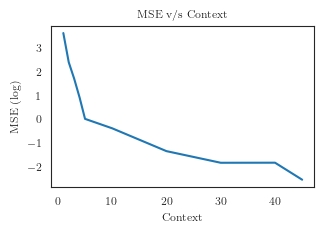

In [ ]:
fig, ax = plt.subplots()  # Width = 3*5 inches, Height = 5 inches
plt.plot(context_points, np.log( np.array(mse_lst_cnp)))
plt.title("MSE v/s Context")
plt.xlabel("Context")
plt.ylabel("MSE (log)")
ax.tick_params(axis='both', which='both', labelsize=8)
plt.savefig("plots/performance_CNP_1d_regression_compare.pdf", format="pdf", bbox_inches="tight")
plt.show()